In [1]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import RidgeClassifierCV
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

import sys

sys.path.append('..')

from sast import *

# Configs

In [2]:
use_rocket = True # use ROCKET if True otherwise use SAST
data_file = 'beflowtkd-export.json'
max_length = 0 # max length of time series. This value will be updated after reading the data

In [3]:
# define the key points to consider
all_key_points = ['rightEye', 'leftEye', 'leftAnkle', 'rightAnkle', 'leftEar', 'rightEar', 'leftElbow', 'rightElbow', 'leftHip', 'rightHip', 'leftKnee', 'rightKnee', 'leftShoulder', 'rightShoulder', 'leftWrist', 'rightWrist', 'nose']
ignored_key_points = set(['rightEye', 'leftEye'])
key_points = list(filter(lambda x: x not in ignored_key_points, all_key_points))

# Dataset

In [4]:
tkd_raw_data = pd.read_json(data_file)
tkd_raw_data

counters            description  \
ap_chagi               40  Tkd moves time series   
bandal_chagi           40  Tkd moves time series   
dwi_huryo_chagi        40  Tkd moves time series   

                                                             moves  
ap_chagi         {'-MQgr-qd8xkXlgAzU_Qo': {'confidence': '0.959...  
bandal_chagi     {'-MQgswQfPw9gnraQQ2i4': {'confidence': '0.929...  
dwi_huryo_chagi  {'-MRfVSa7UC48EhapAYXK': {'confidence': '0.931...

In [5]:
classes = tkd_raw_data.index.tolist()
print(classes)

['ap_chagi', 'bandal_chagi', 'dwi_huryo_chagi']


In [6]:
classes2int = {c: i for i, c in enumerate(classes)}
print(classes2int)

{'ap_chagi': 0, 'bandal_chagi': 1, 'dwi_huryo_chagi': 2}


In [7]:
int2classes = {i: c for i, c in enumerate(classes)}
print(int2classes)

{0: 'ap_chagi', 1: 'bandal_chagi', 2: 'dwi_huryo_chagi'}


## Visualization

In [8]:
tkd_raw_data.loc['ap_chagi']

counters                                                      40
description                                Tkd moves time series
moves          {'-MQgr-qd8xkXlgAzU_Qo': {'confidence': '0.959...
Name: ap_chagi, dtype: object

In [9]:
import copy
sample_ap_chagi = copy.deepcopy(tkd_raw_data.loc['ap_chagi'].moves['-MQgr89W8cMidU8qDMeZ'])

for kp in key_points:
    sample_ap_chagi[kp]['x'] = 1 - np.fromstring(sample_ap_chagi[kp]['x'], sep=",") # So right joints are at my right and left joints are at my left
    sample_ap_chagi[kp]['y'] = 1 - np.fromstring(sample_ap_chagi[kp]['y'], sep=",") # because the origin of posenet is top left

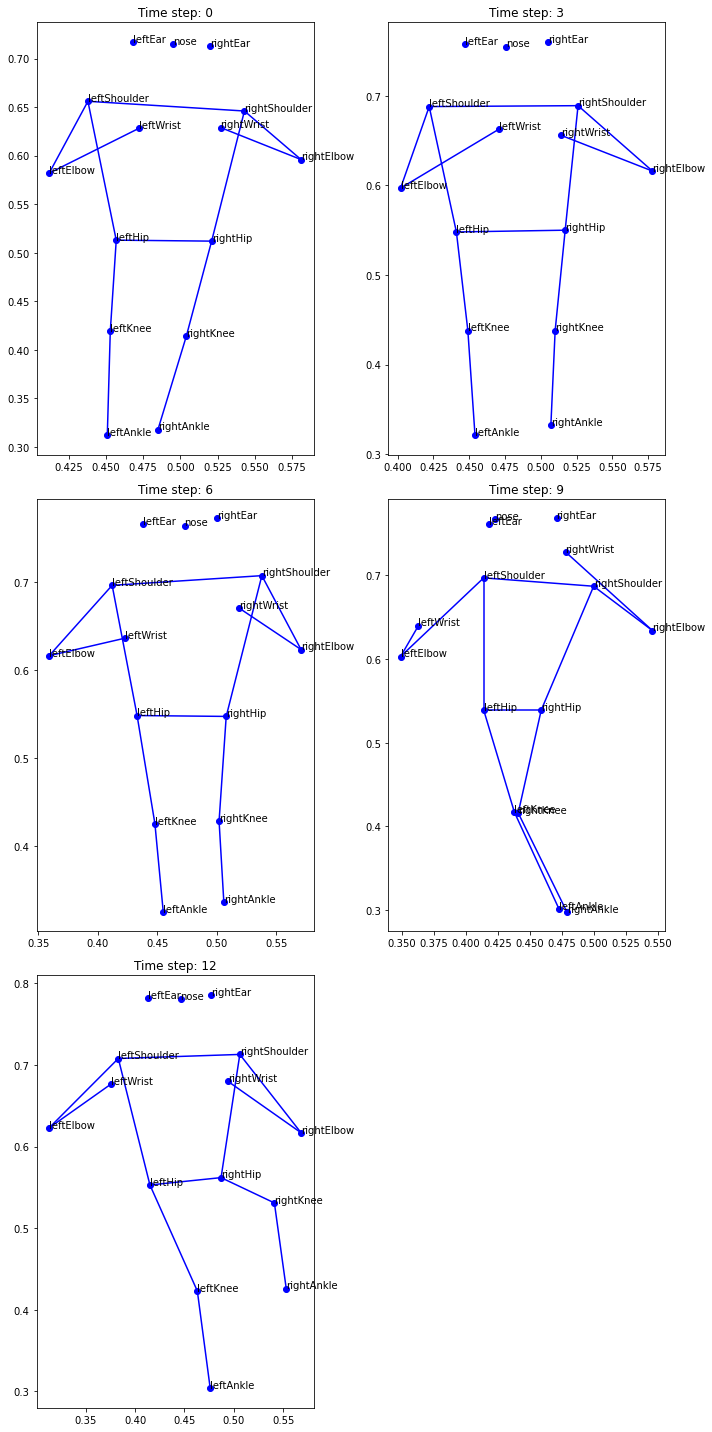

In [10]:
def add_link(move, kp1, kp2, color='blue'):
    plt.plot([move[kp1]['x'][pos], move[kp2]['x'][pos]], [move[kp1]['y'][pos], move[kp2]['y'][pos]], 'b-', c=color)

color = 'blue'
step = 3

plt.figure(figsize=(10, 20), tight_layout=True)
for i, pos in enumerate(range(0, 15, 3)):
    
    plt.subplot(3, 2, i+1)
    plt.title(f'Time step: {pos}')
    for kp in key_points:
        x, y = sample_ap_chagi[kp]['x'][pos], sample_ap_chagi[kp]['y'][pos]
        plt.plot(x, y, 'bo')
        plt.annotate(kp, (x, y))

    # left-left joints
    add_link(sample_ap_chagi, 'leftShoulder', 'leftElbow', color)
    add_link(sample_ap_chagi, 'leftElbow', 'leftWrist', color)
    add_link(sample_ap_chagi, 'leftShoulder', 'leftHip', color)
    add_link(sample_ap_chagi, 'leftHip', 'leftKnee', color)
    add_link(sample_ap_chagi, 'leftKnee', 'leftAnkle', color)

    # right-right joints
    add_link(sample_ap_chagi, 'rightShoulder', 'rightElbow', color)
    add_link(sample_ap_chagi, 'rightElbow', 'rightWrist', color)
    add_link(sample_ap_chagi, 'rightShoulder', 'rightHip', color)
    add_link(sample_ap_chagi, 'rightHip', 'rightKnee', color)
    add_link(sample_ap_chagi, 'rightKnee', 'rightAnkle', color)

    # left-right joints
    add_link(sample_ap_chagi, 'leftHip', 'rightHip', color)
    add_link(sample_ap_chagi, 'leftShoulder', 'rightShoulder', color)
plt.savefig('images/sample_ap_chagi.jpg')

In [11]:
nb_moves_per_class = 2

fig, axes = plt.subplots(ncols=len(classes) * nb_moves_per_class, nrows=len(key_points), figsize=(15, 30), tight_layout=True, sharex=False)

for j, c in enumerate(classes):
    moves = np.random.choice(list(tkd_raw_data.loc[c].moves.values()), size=nb_moves_per_class, replace=False)
    while any(map(lambda x: len(x['confidence']) == 0, moves)):
        moves = np.random.choice(list(tkd_raw_data.loc[c].moves.values()), size=nb_moves_per_class, replace=False)
    for i, kp in enumerate(key_points):
        for k, move in enumerate(moves):
            col = j * nb_moves_per_class + k
            axes[i, col].plot(np.fromstring(move[kp]['x'], sep=','), label='x')
            axes[i, col].plot(np.fromstring(move[kp]['y'], sep=','), label='y')
            axes[i, col].legend()
            if col == 0:
                axes[i, col].set_ylabel(kp, fontsize=16)
            if i == 0:
                axes[i, col].set_title(c, fontsize=16)
fig.savefig("images/sample_viz.jpg")

# Format the dataset

In [10]:
def format_series(series, max_length):
    series_len = len(series)
    if series_len < max_length:
        queue = [np.mean(series)] * (max_length - series_len)
        return np.concatenate([series, queue])
    return series

def format_json_move(move, max_length):
    xaxis = []
    yaxis = []
    for kp in key_points:
        x_series = np.array(move[kp]['x'].split(','), dtype=np.float32)
        y_series = np.array(move[kp]['y'].split(','), dtype=np.float32)
        xaxis.append(format_series(x_series, max_length))
        yaxis.append(format_series(y_series, max_length))
    return {'x': np.concatenate(xaxis), 'y': np.concatenate(yaxis)}

In [11]:
tkd_data_dict = {f'{kp}_x': [] for kp in key_points} # the x-axis
tkd_data_dict.update({f'{kp}_y': [] for kp in key_points}) # the y-axis
tkd_data_targets = []
nb_moves = 0
for c, row in tkd_raw_data.iterrows():
    for _, move in row.moves.items():
        if len(move['confidence']) == 0:
            continue
        nb_moves += 1
        
        tkd_data_targets.append(classes2int[c])
        
        for kp in key_points:
            x_series = np.array(move[kp]['x'].split(','), dtype=np.float32)
            y_series = np.array(move[kp]['y'].split(','), dtype=np.float32)
            tkd_data_dict[f'{kp}_x'].append(x_series)
            tkd_data_dict[f'{kp}_y'].append(y_series)
            max_length = max(max_length, len(x_series))
            max_length = max(max_length, len(y_series))
print(max_length)

32


In [12]:
tkd_data_xaxis = np.zeros((nb_moves, max_length * len(key_points)))
tkd_data_yaxis = np.zeros_like(tkd_data_xaxis)
tkd_data_targets = np.array(tkd_data_targets)

print('xaxis.shape: ', tkd_data_xaxis.shape) 
print('yaxis.shape: ', tkd_data_yaxis.shape) 
print('targets.shape', tkd_data_targets.shape)

xaxis.shape:  (120, 480)
yaxis.shape:  (120, 480)
targets.shape (120,)


In [13]:
# concat every keypoints
ix = 0
iy = 0
order = []
for i, (k, data) in enumerate(tkd_data_dict.items()):
    if k[-2:] == '_x':
        order.append(k[:-2])
        s = ix * max_length
        e = s + max_length
        ix += 1
        tkd_data_xaxis[:,s:e] = np.array([format_series(d, max_length) for d in data])
    else:
        s = iy * max_length
        e = s + max_length
        iy += 1
        tkd_data_yaxis[:,s:e] = np.array([format_series(d, max_length) for d in data])
print("Order: ", order)

Order:  ['leftAnkle', 'rightAnkle', 'leftEar', 'rightEar', 'leftElbow', 'rightElbow', 'leftHip', 'rightHip', 'leftKnee', 'rightKnee', 'leftShoulder', 'rightShoulder', 'leftWrist', 'rightWrist', 'nose']


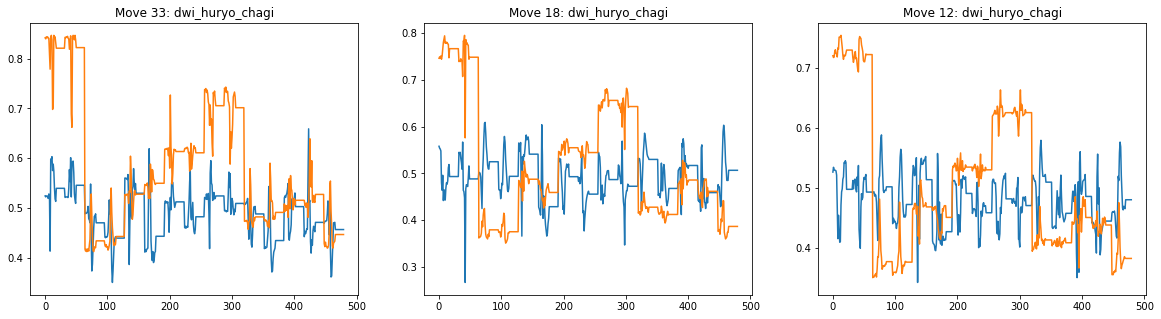

In [14]:
nb_moves_per_class = 3
for c in int2classes:
    count = len(tkd_data_targets[tkd_data_targets==c])
    indices = np.random.choice(np.arange(count), size=nb_moves_per_class, replace=False)
    plt.figure(figsize=(20, 5))
    for p, i in enumerate(indices):
        plt.subplot(1, nb_moves_per_class, p+1)
        plt.plot(tkd_data_xaxis[tkd_data_targets==c][i], label='x-axis')
        plt.plot(tkd_data_yaxis[tkd_data_targets==c][i], label='y-axis')
        plt.title(f'Move {i+1}: {int2classes[c]}')
plt.savefig("images/sample_viz_bivariate.jpg")

# Building and train the model

In [15]:
def create_model(trainX, trainy, max_length):
#     clf = RidgeClassifierCV(alphas = np.logspace(-3, 3, 10))
    clf = RandomForestClassifier()
    model = None
    if use_rocket:
        model = RocketClassifier(clf=clf, lr_clf=False)
    else:
        model = SAST(cand_length_list=np.arange(3, max_length + 1),
                          nb_inst_per_class=1, classifier=clf)
    model.fit(trainX, trainy)
    
    return model

In [16]:
shuffle_indices = np.random.permutation(tkd_data_xaxis.shape[0])
X_train_xaxis = tkd_data_xaxis[shuffle_indices]
X_train_yaxis = tkd_data_yaxis[shuffle_indices]
y_train = tkd_data_targets[shuffle_indices]

In [17]:
start_time = time.time()

model = {
    'model_xaxis': create_model(X_train_xaxis, y_train, max_length), 
    'model_yaxis': create_model(X_train_yaxis, y_train, max_length)
}

end_time = time.time()
print('Model built and trained in', end_time - start_time, 'seconds')

Model built and trained in 6.074252128601074 seconds


In [18]:
def predict_move(model, move):
    pred_xaxis = model['model_xaxis'].predict_proba(np.expand_dims(move['x'], axis=0).astype(np.float64))
    pred_yaxis = model['model_yaxis'].predict_proba(np.expand_dims(move['y'], axis=0).astype(np.float64))
    pred = (pred_xaxis + pred_yaxis)/2
    return np.argmax(pred), np.max(pred)*100

# Model score on training data

In [19]:
pred_xaxis = model['model_xaxis'].predict_proba(tkd_data_xaxis)

In [20]:
pred_yaxis = model['model_yaxis'].predict_proba(tkd_data_yaxis)

In [21]:
pred = np.argmax((pred_xaxis + pred_yaxis) / 2, axis=1)
P, R, F1, _ = precision_recall_fscore_support(tkd_data_targets, pred, average='macro')
print("Precision:", P)
print("Recall:", R)
print("F1-score:", F1)
confusion_matrix(tkd_data_targets, pred)

Precision: 1.0
Recall: 1.0
F1-score: 1.0


array([[40,  0,  0],
       [ 0, 40,  0],
       [ 0,  0, 40]])

# Some predictions

In [22]:
keys = list(tkd_raw_data.loc['ap_chagi'].moves.keys())
for k in np.random.choice(keys, size=3):
    formated_move = format_json_move(tkd_raw_data.loc['ap_chagi'].moves[k], max_length)
    pred, confidence = predict_move(model, formated_move)
    print('Prediction:', int2classes[pred], 'Confidence:', confidence)

Prediction: ap_chagi Confidence: 99.5
Prediction: ap_chagi Confidence: 99.0
Prediction: ap_chagi Confidence: 82.0


In [23]:
keys = list(tkd_raw_data.loc['bandal_chagi'].moves.keys())
for k in np.random.choice(keys, size=3):
    formated_move = format_json_move(tkd_raw_data.loc['bandal_chagi'].moves[k], max_length)
    pred, confidence = predict_move(model, formated_move)
    print('Prediction:', int2classes[pred], 'Confidence:', confidence)

Prediction: bandal_chagi Confidence: 77.0
Prediction: bandal_chagi Confidence: 92.0
Prediction: bandal_chagi Confidence: 90.0


# Saving the models

In [24]:
from joblib import dump, load

In [25]:
for k, m in model.items():
    dump(m, f'models/tkd_{k}_bivariate_rocket.joblib')